<h1>Система распознавания пола диктора</h1>

Нужно обучить модель распознавания пола диктора.
В файле f.txt перечислены женские голоса, в файле m.txt мужские голоса.
В папке wav_data аудио файлы в формате PCM 8000 Гц, 16 бит.

In [114]:
%matplotlib inline
import librosa
import numpy as np
import matplotlib.pyplot as plt
import librosa.display

In [9]:
#Считаем список названий женских и мужских голосов
with open('male.txt','r') as f1,open('female.txt','r') as f2:
    male=list(map(lambda x: x[:-1],f1.readlines()))
    female=list(map(lambda x: x[:-1],f2.readlines()))

In [18]:
#Попробуем воспроизвести какой-нибудь из файлов
import IPython.display as ipd
ipd.Audio('wav_data\\{}'.format(male[0]))

В файле много тишины в начале и конце. Имеет смысл в пайплайне автоматически обрезать тишину

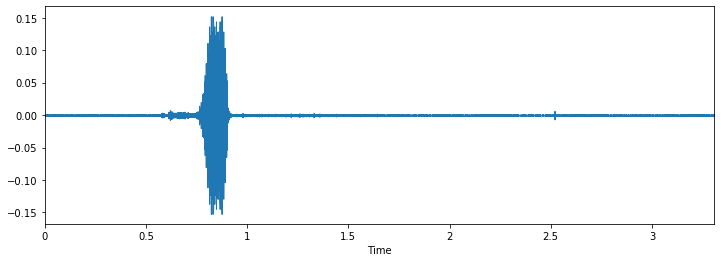

In [115]:
x,sr = librosa.load('wav_data\\{}'.format(male[0]), sr=None)
plt.figure(figsize=(12, 4))
librosa.display.waveplot(x, sr=sr)  #посстроим осцилограмму файла

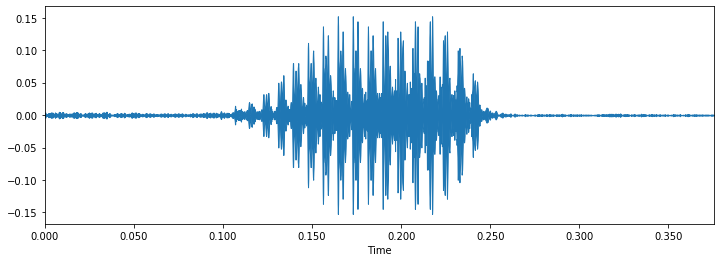

In [116]:
#обрежем тишину. Порог 20дБ и значение frame_length подобранны экспериментально
x,_ = librosa.effects.trim(x, top_db=20, frame_length=2048, hop_length=64) 
plt.figure(figsize=(12, 4))
librosa.display.waveplot(x, sr=sr)

In [122]:
def get_spectrum(fname):
    x,_ = librosa.load('wav_data\\{}'.format(fname), sr=None)
    x,_ = librosa.effects.trim(x, top_db=20, frame_length=2048, hop_length=64) 
    return librosa.stft(x,n_fft = 2048)

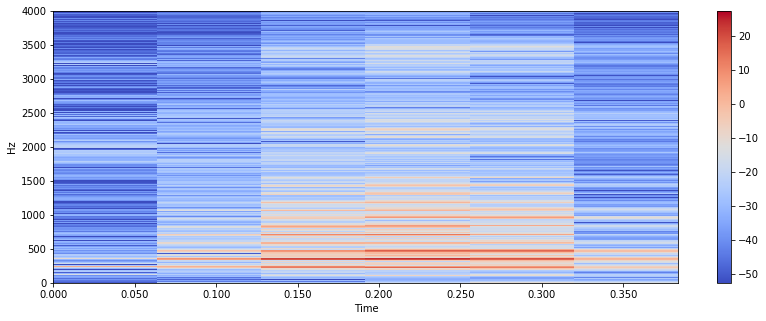

In [123]:
#попробуем построить спектрограмму
X = get_spectrum(male[0])
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

<h2> Часть про статистику и обоснование метода(можно пропустить)</h2>

Основная идея решения - женские голоса должны быть в среднем выше мужских. Для каждого сэмпла построим усредненную по времени спектрограмму (Фурье-преобразование). Для женских  и мужских голосов средние значения и медианы спектрограмм должны статистически значимо отличаться

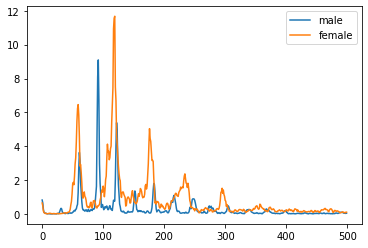

In [125]:
#сравним визуально случайные мужской и женский сэмплы
plt.plot(np.mean(np.abs(get_spectrum(male[0])),axis=1)[:500],label='male')
plt.plot(np.mean(np.abs(get_spectrum(female[0])),axis=1)[:500],label='female')
plt.legend()

Модуль librosa позволяет рассчитать спектральный центр, который указывает, на какой частоте сосредоточена энергия спектра или, другими словами, указывает, где расположен “центр масс” для звука. Схож со средневзвешенным значением:

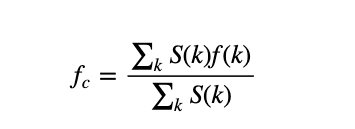



где S(k) — спектральная величина элемента разрешения k, а f(k) — частота элемента k.

Рассчитаем средние по времени значения спектрального центра для всех сэмплов и проверим гипотезу, что они различны для мужской и женской выборок

In [126]:
centers = [[],[]]
for ind,gender in enumerate((male,female)):
    for filename in gender:
        audio, sr = librosa.load('wav_data\\{}'.format(filename), mono=True)
        audio, _ = librosa.effects.trim(audio, top_db=20, frame_length=2048, hop_length=64)
        centers[ind].append(np.mean(librosa.feature.spectral_centroid(y=audio, sr=sr)))


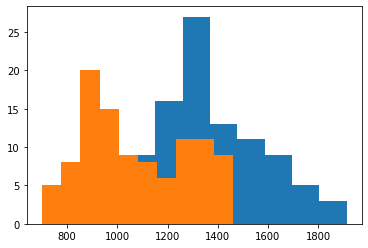

In [131]:
plt.hist(centers[0]);
plt.hist(centers[1]);

In [134]:
from scipy.stats import ttest_ind, normaltest,mannwhitneyu
normaltest(centers[0]),normaltest(centers[1])

(NormaltestResult(statistic=0.3851972971528014, pvalue=0.8248129475670463),
 NormaltestResult(statistic=40.72126548772504, pvalue=1.4371084774575374e-09))

т.к. одно из распределений оказалось далеко от нормального, для их сравнения используем рангорый U-критерий Манна-Уитни. Параметр alternative='greater' означает, что женские голоса в среднем выше

In [136]:
mannwhitneyu(centers[0],centers[1],alternative='greater')

MannwhitneyuResult(statistic=8263.0, pvalue=1.9428122194080118e-13)

Нуль-гипотеза о равнестве распределений отвергнута в пользу альтернативной

<h2>Построение признаков и обучение модели</h2>

Помимо спектрального центра будем также использовать ширину максимальной полосы спектра и мел-частотные кепстральные коэффициенты, которые очень хорошо должны характеризовать тембр голоса

In [71]:
data = np.zeros(23) # будет 22 вещественных признака и целевая переменная
for ind,gender in enumerate((male,female)):
    for filename in gender:
        row = np.zeros(23)
        audio, sr = librosa.load('wav_data\\{}'.format(filename), mono=True) #загрузка файла
        
        audio, _ = librosa.effects.trim(audio, top_db=20, frame_length=2048, hop_length=64) #триммирование тишины
        spec_cent = librosa.feature.spectral_centroid(y=audio, sr=sr)  #спектральный центр
        spec_bw = librosa.feature.spectral_bandwidth(y=audio, sr=sr)  #ширина полосы
        mfcc = librosa.feature.mfcc(y=audio, sr=sr)  #Мел-частотные кепстральные коэффициенты 
        row[0] = ind
        row[1] = np.mean(spec_cent)
        row[2] = np.mean(spec_bw)
        for i in range(20):
            row[i+3] = np.mean(mfcc[i])
        data = np.vstack((data,row))

In [74]:
np.save('data.npy',data) #сохраним полученный датасет

In [189]:
data = np.load('data.npy')

In [192]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X,y = data[:,1:],data[:,0]   #из датасета извлечем признаки и целевую переменную

#X = StandardScaler().fit_transform(X) # если отшкалировать - точность получается хуже
# Разобьем на трейнтестовую(по ней будет обучение с кросс-валидацией) и отложенную выборки
X_tt, X_delayed, y_tt, y_delayed = train_test_split(X, y, test_size=0.1,shuffle = True) 


In [191]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

В качестве модели будет достаточно простой линейной модели с регуляризатором, чтобы отсекать незначимые либо линейно зависимые признаки. Я использую LogisticRegression с поиском по сетке l1 и l2 регулязаторов и кросс-валидацией на 5ти фолдах. В качестве целевой метрики можно выбрать accuracy, т.к. классы сбалансированны и нет разницу между FN и FP ошибками

In [193]:
import warnings
warnings.filterwarnings("ignore")

params = {
    'penalty':['l1', 'l2']
}
grid = GridSearchCV(LogisticRegression(),params,cv=5,scoring='accuracy')
grid.fit(X_tt,y_tt)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None, param_grid={'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [194]:
grid.best_score_  #средняя метрика точности на тестовых выборках

0.9945652173913043

accuracy=1.0


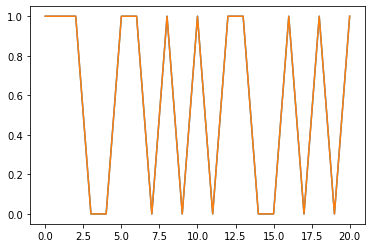

In [195]:
#посмотрим, как модель сработает на отложенной выборке
plt.plot(grid.best_estimator_.predict(X_delayed))
plt.plot(y_delayed)
print('accuracy={}'.format(grid.best_estimator_.score(X_delayed,y_delayed)))

Взглянем на коэффициенты регрессора. Видно, регуляризация занулила некоторые из них

In [196]:
grid.best_estimator_.coef_

array([[-7.51115940e-04, -2.55857611e-02, -5.11138370e-02,
        -4.58558005e-02, -6.57413088e-02, -7.49563617e-02,
        -1.09643980e-01, -3.56656733e-01,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         2.48891157e-01,  0.00000000e+00, -3.69164580e-01,
         2.20783783e-01,  0.00000000e+00, -1.58755234e-01,
         0.00000000e+00,  0.00000000e+00, -7.87116766e-01,
         0.00000000e+00]])

In [197]:
grid.best_estimator_.intercept_

array([0.])

In [198]:
grid.best_params_

{'penalty': 'l1'}

In [199]:
import pickle
with open("model.pkl", 'wb') as f:
    pickle.dump(grid.best_estimator_, f)

<h3>Код для получения одного предсказания</h3>

In [210]:
import librosa
import numpy as np
import warnings
import pickle
warnings.filterwarnings("ignore")
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

filename = female[1]

x = np.zeros(22)
audio, sr = librosa.load('wav_data\\{}'.format(filename), mono=True) #загрузка файла
        
audio, _ = librosa.effects.trim(audio, top_db=20, frame_length=2048, hop_length=64) #триммирование тишины
spec_cent = librosa.feature.spectral_centroid(y=audio, sr=sr)  #спектральный центр
spec_bw = librosa.feature.spectral_bandwidth(y=audio, sr=sr)  #ширина полосы
mfcc = librosa.feature.mfcc(y=audio, sr=sr)  #Мел-частотные кепстральные коэффициенты 
x[0] = np.mean(spec_cent)
x[1] = np.mean(spec_bw)
for i in range(20):
     x[i+2] = np.mean(mfcc[i])
        
        
with open("model.pkl", 'rb') as f:
    model = pickle.load(f)

print('female') if model.predict(x.reshape(1,-1))[0] else print('male')


female
